In [1]:
import pandas as pd

from utils import load_parquet_to_df_list, z_normalize


# load time series dataset into dataframe and z-normalize it
path = "../../../0_data/UCRArchive_2018/SwedishLeaf/train"
df_list = load_parquet_to_df_list(path)


# only select columns with data ('signal') and ignore class labels ('pattern_main_id')
df_norm = pd.concat([z_normalize(df["signal"].to_frame()) for df in df_list], axis=1).iloc[:, :2]
df_norm

,signal,signal
0,2.223633,1.879365
1,2.058567,1.733153
2,1.849589,1.579823
3,1.642328,1.402389
4,1.438219,1.257130
...,...,...
123,1.345195,1.162620
124,1.547908,1.314745
125,1.760490,1.500432
126,1.970141,1.657326


### SAX variants

In [2]:
from discretization.sax.sax import SAX
from discretization.sax.extended_sax import ExtendedSAX
from discretization.sax.adaptive_sax import AdaptiveSAX
from discretization.sax.one_d_sax import OneDSAX
from discretization.persist.persist import Persist


alphabet_size = 9
alphabet_size_avg = 3
alphabet_size_slope = 3

sax = SAX(alphabet_size)
a_sax = AdaptiveSAX(alphabet_size)
e_sax = ExtendedSAX(alphabet_size)
one_d_sax = OneDSAX(alphabet_size_avg=alphabet_size_avg, alphabet_size_slope=alphabet_size_slope)
persist = Persist(alphabet_size)

### Inconsistency Measure
Usually, a supervised measure with discretization bins known for each data point

Data points that have the same features shall be in the same discretization bin

[Inconsistency Measure](https://sci2s.ugr.es/keel/pdf/algorithm/articulo/liu1-2.pdf)

Adapted inconsistency measure for measuring time series discretization quality:

Goal: Same time series points should be mapped to the same symbols (i.e. discretized into the same bins)

In every iteration round, random time series point is chosen and all time series points in epsilon-neighborhood are collected.

Then, it is checked for all points in the epsilon-neighborhood to which symbols (i.e. discretization bins) they are mapped.

absolute inconsistency = #points in epsilon-neighborhood - #points in largest discretization bin (i.e. symbol that most points are mapped to)

--> intuition: symbol that most points are mapped to is seen as the true symbol of the randomly chosen point; points in other bins are mapped to "wrong" symbols

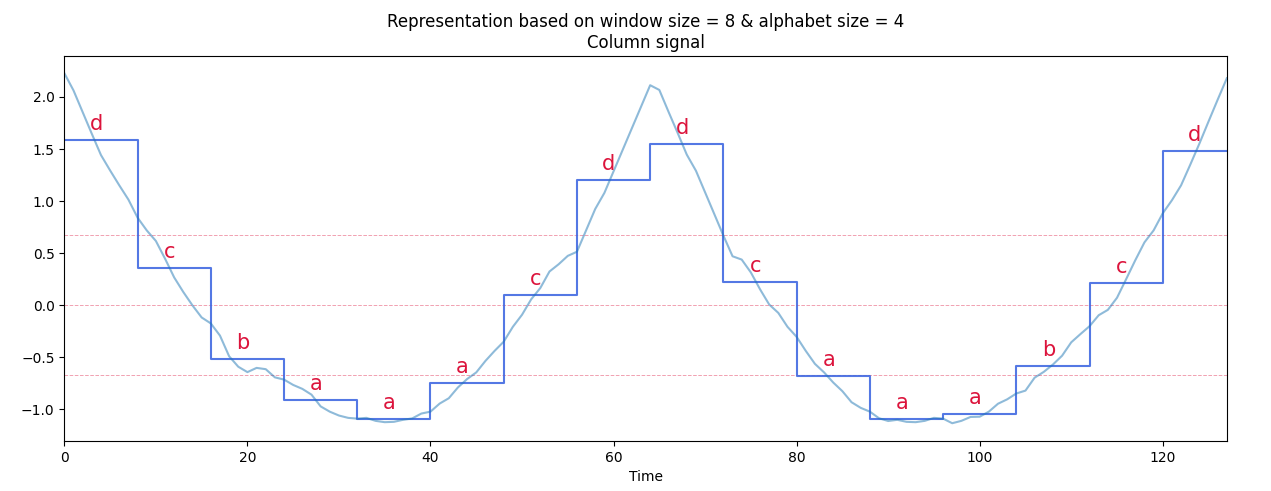

### Parameters for Inconsistency Measure

In [3]:
sax_variant = sax
window_size = 5
epsilon = 0.01

In [4]:
from inconsistency.inconsistency import compute_inconsistency_metrics
from inconsistency.inconsistency_mode import Weighted, Unweighted


# inconsistency rate measures how many points from the epsilon-neighborhood are in "wrong" discretization bins in relation to the #points in epsilon-neighborhood

# relative inconsistency = (sum: #points in epsilon-neighborhood * (absolute inconsistency / #points in epsilon-neighborhood)) / (sum: #points in epsilon-neighborhood)
weighted = Weighted()

# relative inconsistency = (sum: (absolute inconsistency / #points in epsilon-neighborhood)) / #iterations (i.e. #random points chosen)
# --> unweighted mean inconsistency rate per time series point
unweighted = Unweighted()

### Compare SAX variants

In [5]:
#sax_variants = [sax, a_sax, e_sax, one_d_sax, persist]
#inconsistencies = {}
#num_bins = {}
#for sax_variant in sax_variants:
#    incons, bins = compute_inconsistency_metrics(df_norm, window_size, sax_variant, weighted, epsilon)
#    inconsistencies[sax_variant.name] = incons
#    num_bins[sax_variant.name] = bins

In [6]:
from inconsistency.graphics import plot_comparison_inconsistency_metric


#plot_comparison_inconsistency_metric(inconsistencies, 0, "Mean Inconsistency Rate")

In [7]:
# SAX vs. 1d-SAX: 1d-SAX divides time series points across more bins, but there is one bin that contains a lot points
# SAX divides time series points across less bins, but the points are more equally distributed across bins
# therefore, 1d-SAX has a higher number of bins, but a lower inconsistency rate

#plot_comparison_inconsistency_metric(num_bins, 0, "Mean Number of Discretization Bins")

### Sensitivity analysis with epsilon

In [8]:
epsilon_lst = [float("%.9f" % (1e-09 * 10**x)) for x in range(10)]
epsilon_lst

[1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0]

In [9]:
inconsistency_r, bins_r = pd.DataFrame(), pd.DataFrame()
for curr_epsilon in epsilon_lst:
    inconsistency, bins = compute_inconsistency_metrics(df_norm, window_size, sax_variant, unweighted, curr_epsilon)
    inconsistency_r = pd.concat([inconsistency_r, inconsistency.to_frame().T], ignore_index=True)
    bins_r = pd.concat([bins_r, bins.to_frame().T], ignore_index=True)

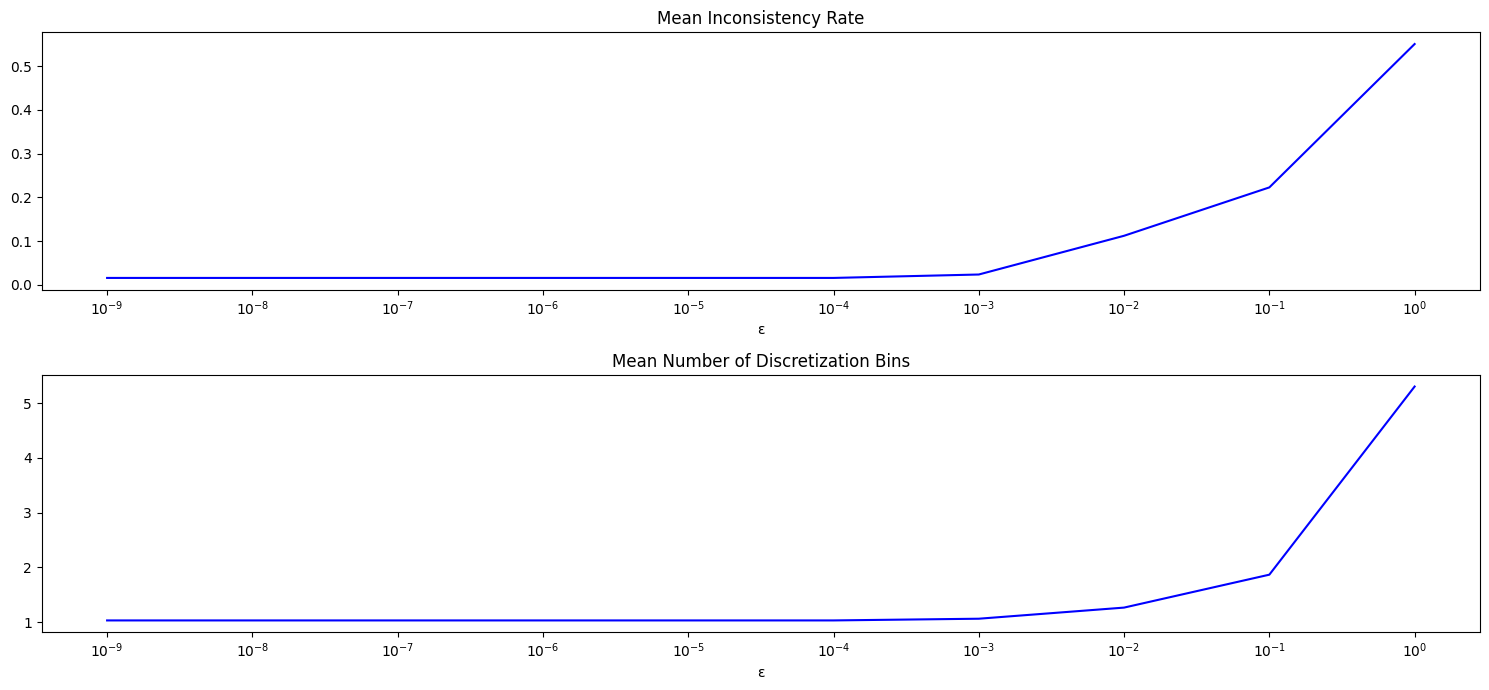

In [10]:
from inconsistency.graphics import plot_inconsistency_metrics


epsilon_symb = "\u03B5"
plot_inconsistency_metrics(inconsistency_r, bins_r, epsilon_lst, 0, x_label=epsilon_symb, x_scale="log")

### Sensitivity analysis with size of alphabet

interesting: inconsistency measure increases with size of alphabet while reconstruction error measure decreases with size of alphabet

--> is there any relationship??

--> open question: optimal alphabet size where | inconsistency - reconstruction error | is minimized??

In [11]:
import numpy as np


min_alphabet_size = 2
max_alphabet_size = 10
alphabet_sizes = np.arange(2, 27)

inconsistency_r, bins_r = pd.DataFrame(), pd.DataFrame()
for alphabet_size in alphabet_sizes:
    sax = SAX(alphabet_size)
    inconsistency, bins = compute_inconsistency_metrics(df_norm, window_size, sax, unweighted, epsilon)
    inconsistency_r = pd.concat([inconsistency_r, inconsistency.to_frame().T], ignore_index=True)
    bins_r = pd.concat([bins_r, bins.to_frame().T], ignore_index=True)

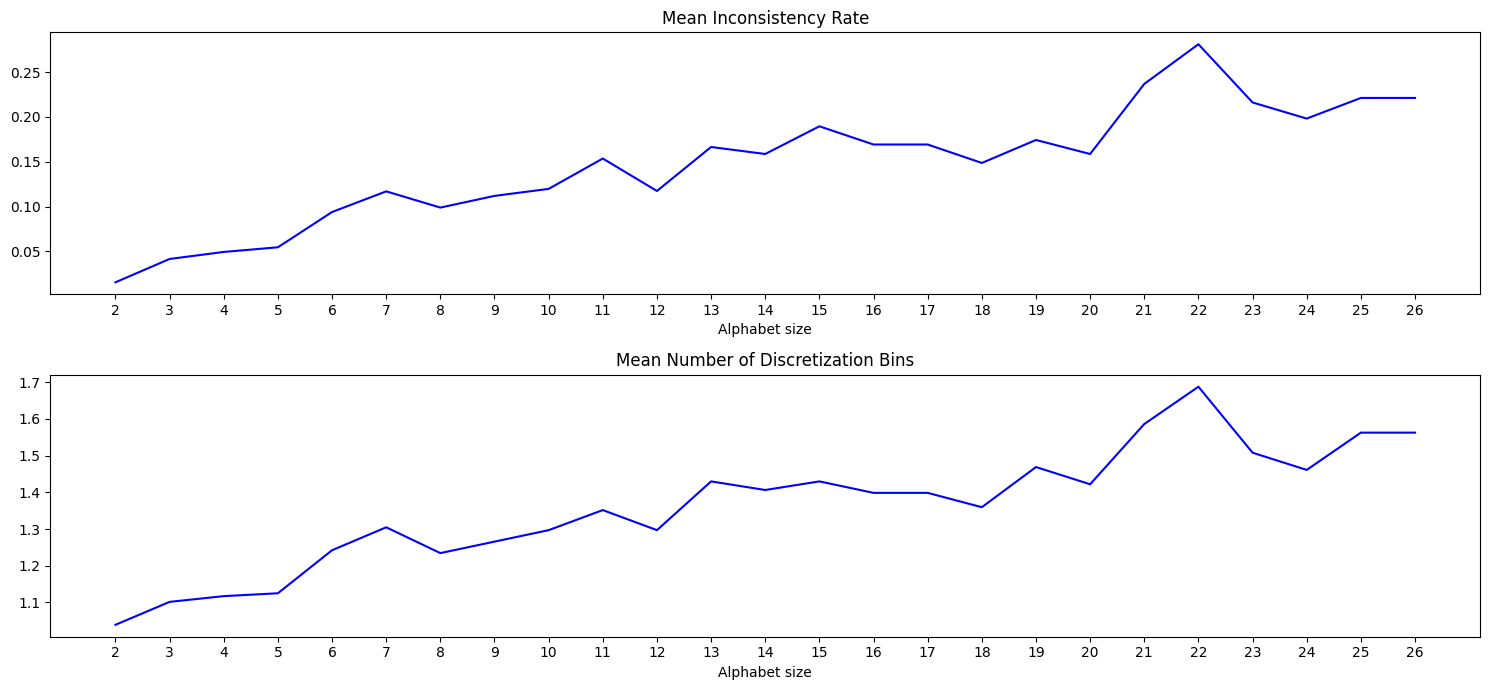

In [12]:
plot_inconsistency_metrics(inconsistency_r, bins_r, alphabet_sizes, 0, x_label="Alphabet size", x_scale="linear")